In [24]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
import pickle
import os

In [25]:
# Set up plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Download data
print("Downloading dataset...")
path = kagglehub.dataset_download("sidharth178/car-prices-dataset")
print(f"Dataset downloaded to {path}")

# Load data
df = pd.read_csv(path + "/train.csv")
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset downloaded to /home/clemt/.cache/kagglehub/datasets/sidharth178/car-prices-dataset/versions/1
Loaded dataset with 19237 rows and 18 columns.


In [26]:
print("\nDataset info:")
df.info()


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 n

In [27]:
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
         ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver 

In [28]:
# Check for missing values
print("\nChecking for missing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if any(missing_values > 0) else "No missing values found.")


Checking for missing values:
No missing values found.


In [29]:
print("\nDataset Overview:")
print(f"Number of vehicles: {len(df)}")
print(f"Number of unique manufacturers: {df['Manufacturer'].nunique()}")
print(f"Number of unique models: {df['Model'].nunique()}")
print(f"Vehicle production years: from {df['Prod. year'].min()} to {df['Prod. year'].max()}")
print(f"Price range: ${df['Price'].min()} to ${df['Price'].max()}")


Dataset Overview:
Number of vehicles: 19237
Number of unique manufacturers: 65
Number of unique models: 1590
Vehicle production years: from 1939 to 2020
Price range: $1 to $26307500


In [30]:
def clean_data(df):
    """
    Comprehensive data cleaning function for car price dataset
    """
    print("\nCleaning data...")
    df_clean = df.copy()
    
    # 1. Fix data types and formats
    print("Fixing data types...")
    # Fix Engine volume (separate Turbo indicator)
    df_clean['Turbo'] = df_clean['Engine volume'].str.contains('Turbo').astype(int)
    df_clean['Engine volume'] = df_clean['Engine volume'].str.replace(' Turbo', '').astype(float)
    
    # Fix mileage
    df_clean['Mileage'] = df_clean['Mileage'].str.replace(' km', '').astype(float)
    
    # Fix categorical variables
    df_clean['Leather interior'] = df_clean['Leather interior'].map({'Yes': 1, 'No': 0})
    df_clean['Wheel'] = df_clean['Wheel'].map({'Right wheel': 1, 'Left wheel': 0})
    
    # 2. Remove outliers and invalid entries
    print("Removing outliers and invalid entries...")
    # Filter unrealistic prices
    min_price = 1000  # Minimum realistic price
    df_clean = df_clean[df_clean['Price'] >= min_price]
    
    # Identify new cars (for mileage check)
    current_year = 2024
    df_clean['is_new'] = (current_year - df_clean['Prod. year']) <= 1
    
    # Handle suspicious mileage values
    condition = ((df_clean['Mileage'] > 0) | 
                ((df_clean['Mileage'] == 0) & (df_clean['is_new'])))
    df_clean = df_clean[condition]
    
    # Remove extreme prices using IQR
    Q1 = df_clean['Price'].quantile(0.10)
    Q3 = df_clean['Price'].quantile(0.90)
    IQR = Q3 - Q1
    max_price = Q3 + 1.5 * IQR
    df_clean = df_clean[df_clean['Price'] <= max_price]
    
    # Remove duplicates
    original_count = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    print(f"Removed {original_count - len(df_clean)} duplicates.")
    
    # 3. Feature engineering
    print("Creating new features...")
    # Add car age
    df_clean['Car_Age'] = current_year - df_clean['Prod. year']
    
    # Add price per year and price per km
    df_clean['Price_per_year'] = df_clean['Price'] / df_clean['Car_Age'].clip(lower=1)
    df_clean['Price_per_km'] = df_clean['Price'] / (df_clean['Mileage'] + 1)  # +1 to avoid division by zero
    
    # Add engine related features
    df_clean['Engine_Age_Ratio'] = df_clean['Engine volume'] / df_clean['Car_Age'].clip(lower=1)
    df_clean['Cylinders_per_liter'] = df_clean['Cylinders'] / df_clean['Engine volume'].clip(lower=0.1)
    
    # 4. Handle high-cardinality categories
    print("Handling high-cardinality categories...")
    # Handle rare car models
    model_counts = df_clean['Model'].value_counts()
    rare_threshold = 10
    mask = df_clean['Model'].isin(model_counts[model_counts < rare_threshold].index)
    df_clean.loc[mask, 'Model'] = df_clean.loc[mask].apply(
        lambda x: f"Other_{x['Manufacturer']}", axis=1)
    
    # Remove temporary columns
    df_clean = df_clean.drop('is_new', axis=1)
    
    print(f"Data cleaning completed. Remaining rows: {len(df_clean)}")
    return df_clean

In [31]:
# Clean the data
df_cleaned = clean_data(df)


Cleaning data...
Fixing data types...
Removing outliers and invalid entries...
Removed 250 duplicates.
Creating new features...
Handling high-cardinality categories...
Data cleaning completed. Remaining rows: 15738


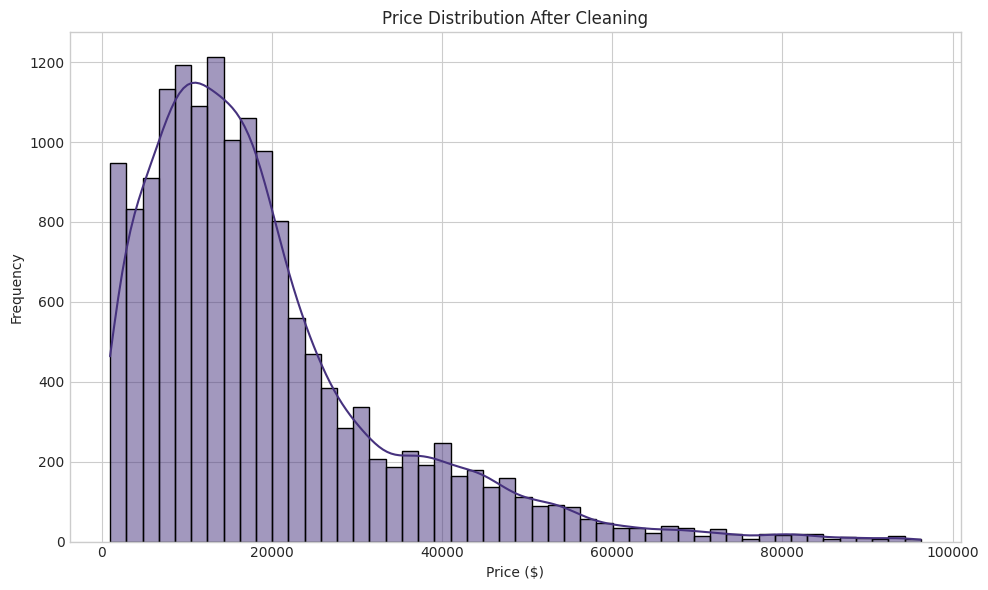

/tmp/ipykernel_1968/1413958172.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45, ha='right')


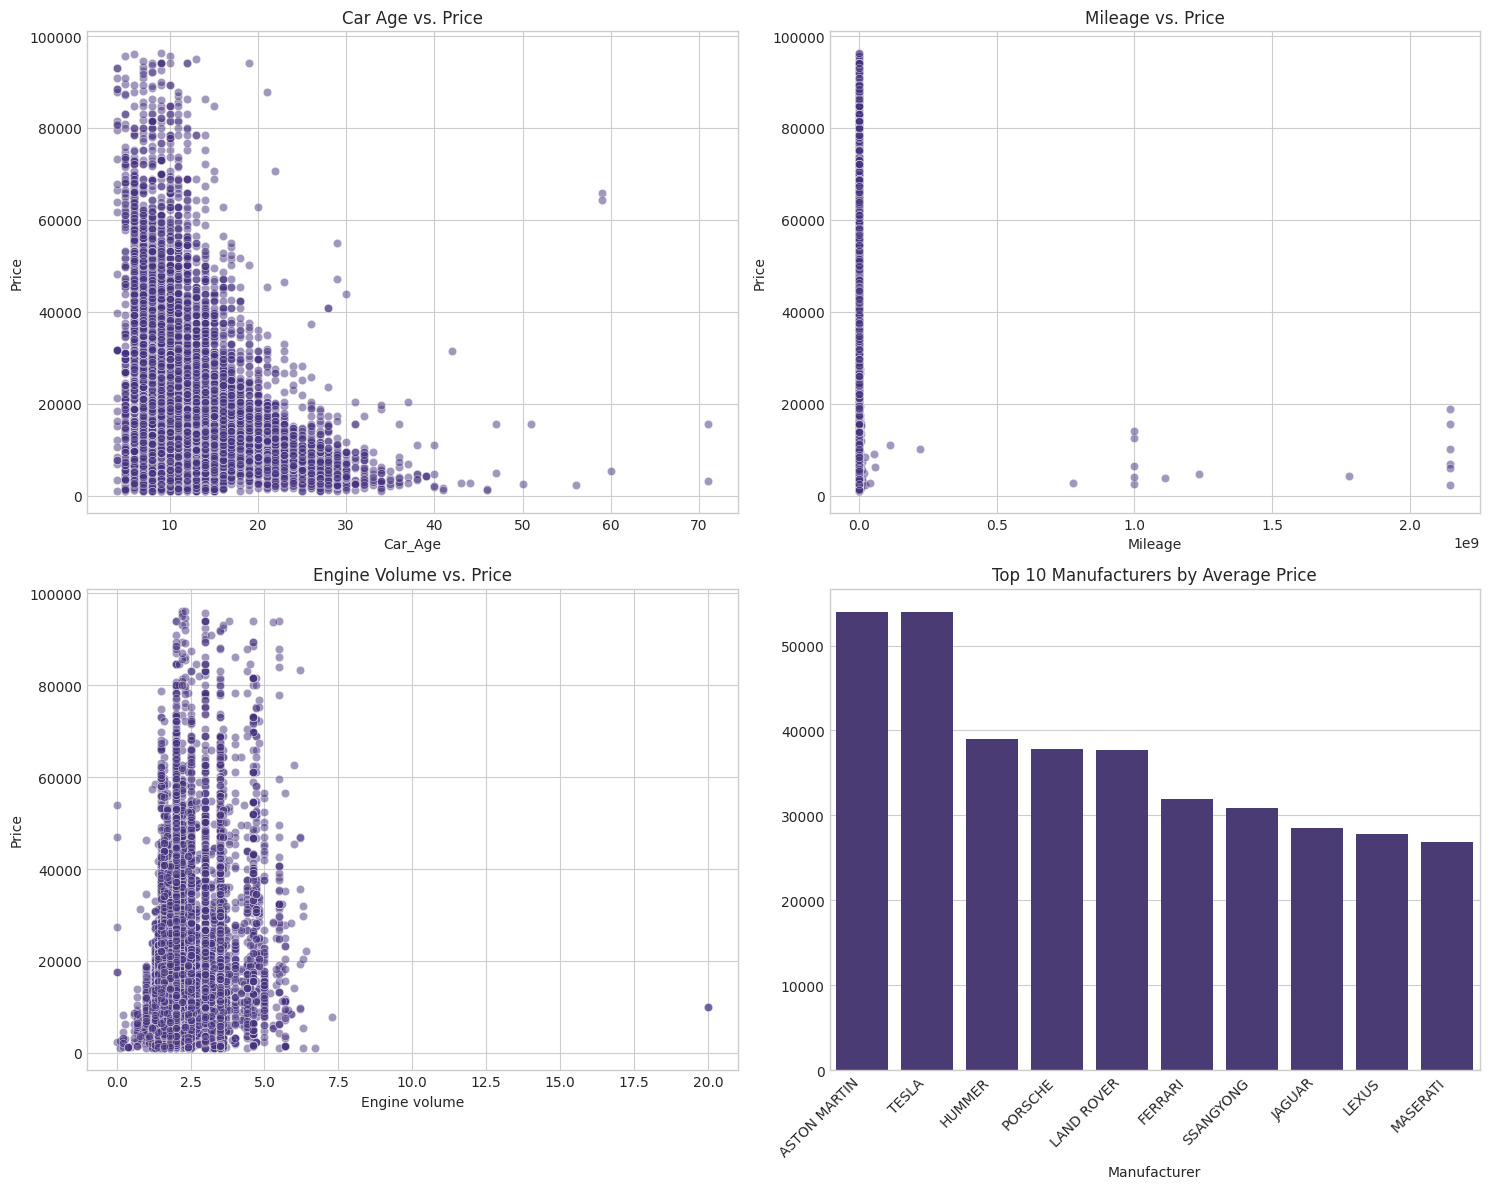

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Price'], kde=True, bins=50)
plt.title('Price Distribution After Cleaning')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Visualize relationships between key features and price
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Car age vs. Price
sns.scatterplot(x='Car_Age', y='Price', data=df_cleaned, alpha=0.5, ax=axs[0, 0])
axs[0, 0].set_title('Car Age vs. Price')

# Mileage vs. Price
sns.scatterplot(x='Mileage', y='Price', data=df_cleaned, alpha=0.5, ax=axs[0, 1])
axs[0, 1].set_title('Mileage vs. Price')

# Engine volume vs. Price
sns.scatterplot(x='Engine volume', y='Price', data=df_cleaned, alpha=0.5, ax=axs[1, 0])
axs[1, 0].set_title('Engine Volume vs. Price')

# Top manufacturers by average price
top_manufacturers = df_cleaned.groupby('Manufacturer')['Price'].mean().nlargest(10)
sns.barplot(x=top_manufacturers.index, y=top_manufacturers.values, ax=axs[1, 1])
axs[1, 1].set_title('Top 10 Manufacturers by Average Price')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

/tmp/ipykernel_1968/2642017968.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1968/2642017968.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


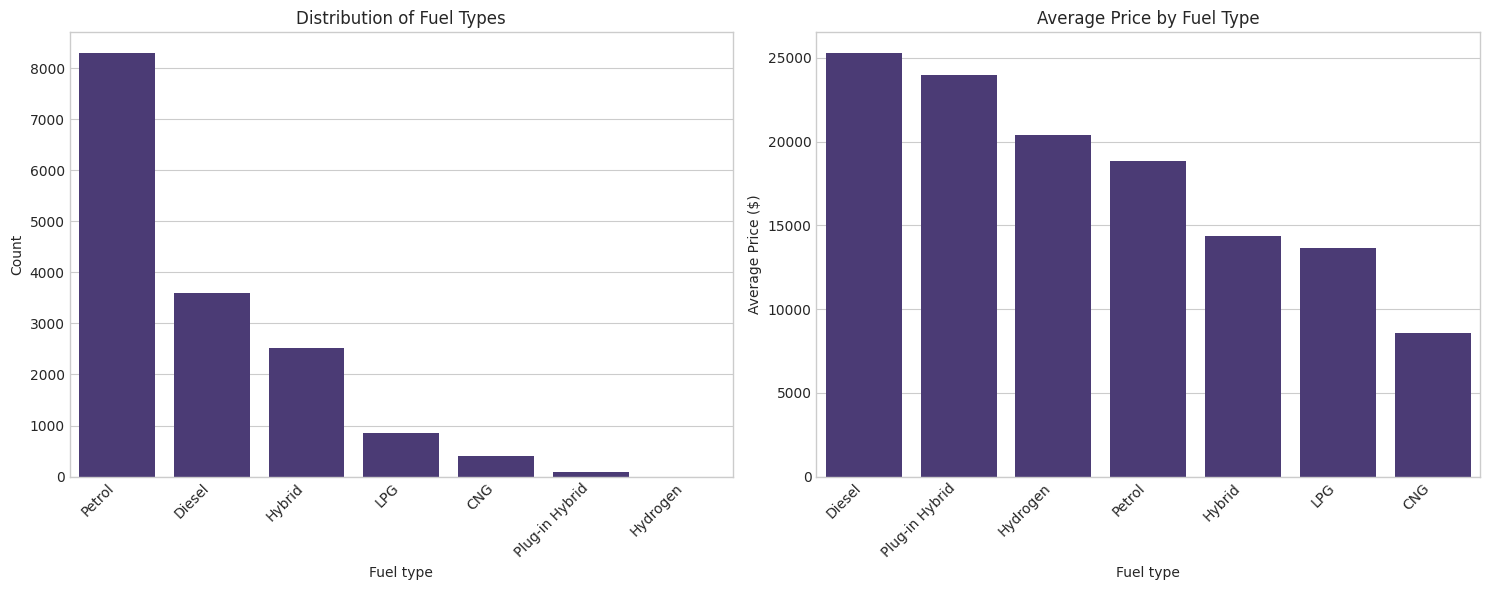

In [33]:
# Fuel type distribution and average price by fuel type
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Fuel type distribution
fuel_counts = df_cleaned['Fuel type'].value_counts()
sns.barplot(x=fuel_counts.index, y=fuel_counts.values, ax=ax1)
ax1.set_title('Distribution of Fuel Types')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_ylabel('Count')

# Average price by fuel type
avg_price_by_fuel = df_cleaned.groupby('Fuel type')['Price'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price_by_fuel.index, y=avg_price_by_fuel.values, ax=ax2)
ax2.set_title('Average Price by Fuel Type')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_ylabel('Average Price ($)')

plt.tight_layout()
plt.show()

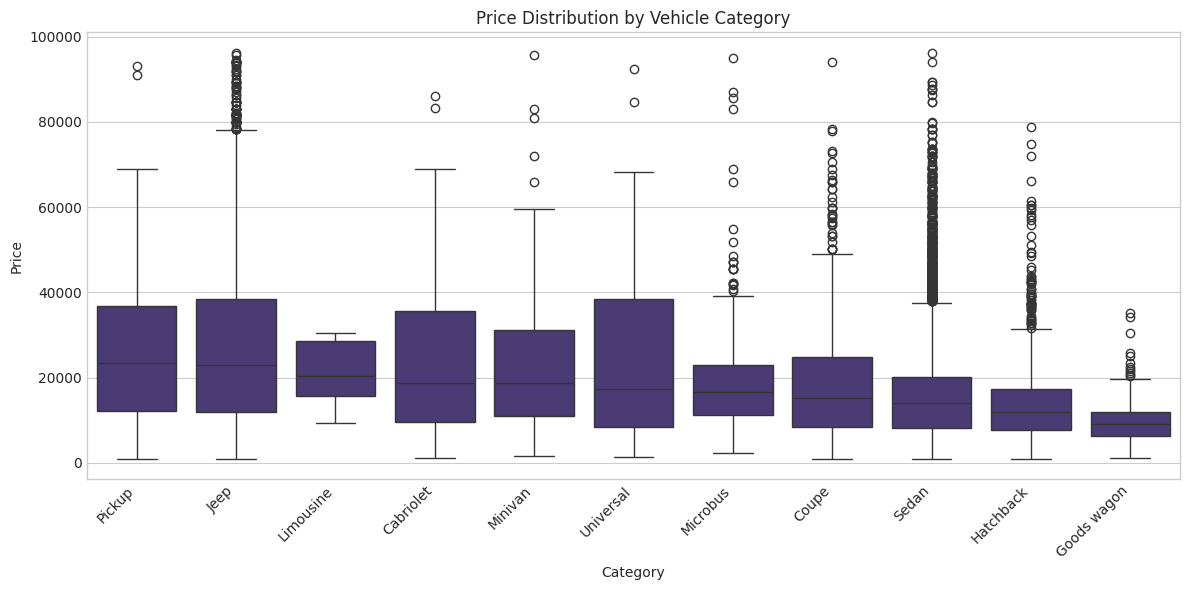

In [34]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Price', data=df_cleaned, order=df_cleaned.groupby('Category')['Price'].median().sort_values(ascending=False).index)
plt.title('Price Distribution by Vehicle Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [35]:
print("\nPreparing features and target...")

# Identify feature types
numeric_features = ['Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags',
                   'Car_Age', 'Price_per_year', 'Price_per_km', 'Engine_Age_Ratio', 'Cylinders_per_liter']
categorical_features = ['Manufacturer', 'Model', 'Category', 'Fuel type', 
                      'Gear box type', 'Drive wheels', 'Color', 'Levy', 'Doors']
binary_features = ['Leather interior', 'Wheel', 'Turbo']

# Drop ID column if it exists
if 'ID' in df_cleaned.columns:
    df_cleaned = df_cleaned.drop('ID', axis=1)

# Check for any remaining missing values
print("\nChecking for missing values after cleaning:")
missing_values = df_cleaned.isnull().sum()
print(missing_values[missing_values > 0] if any(missing_values > 0) else "No missing values found.")

# Fix any remaining missing values
for col in df_cleaned.columns:
    if df_cleaned[col].isnull().sum() > 0:
        if col in numeric_features:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
        else:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

# Separate features and target
X = df_cleaned.drop('Price', axis=1)
y = df_cleaned['Price']


Preparing features and target...

Checking for missing values after cleaning:
Wheel    1250
dtype: int64


In [36]:
print("Splitting data into train, validation, and test sets...")
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Splitting data into train, validation, and test sets...
Training set size: 9442 samples
Validation set size: 3148 samples
Test set size: 3148 samples


In [37]:
print("\nCreating preprocessing pipeline...")

# Define transformers with imputers to handle any missing values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Column transformer that applies the right transformation to each column type
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

# Initialize and fit the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit preprocessing pipeline on training data
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_val_processed = preprocessing_pipeline.transform(X_val)
X_test_processed = preprocessing_pipeline.transform(X_test)

print(f"Processed feature dimensions: {X_train_processed.shape[1]} features")

# Check for NaN values in processed data
print("\nChecking for NaN values in processed data:")
nan_count = np.isnan(X_train_processed).sum()
print(f"Found {nan_count} NaN values in processed training data")

# Handle any NaN values if present
if nan_count > 0:
    print("Handling remaining NaN values by imputation")
    imputer = SimpleImputer(strategy='mean')
    X_train_processed = imputer.fit_transform(X_train_processed)
    X_val_processed = imputer.transform(X_val_processed)
    X_test_processed = imputer.transform(X_test_processed)
    
    # Verify NaN values are gone
    print(f"After imputation: {np.isnan(X_train_processed).sum()} NaN values remain")
    with open('model_artifacts/imputer.pkl', 'wb') as f:
        pickle.dump(imputer, f)


Creating preprocessing pipeline...
Processed feature dimensions: 805 features

Checking for NaN values in processed data:
Found 0 NaN values in processed training data


In [38]:
print("\nPerforming feature selection...")
selector = SelectKBest(f_regression, k='all')
selector.fit(X_train_processed, y_train)


Performing feature selection...


SelectKBest(k='all', score_func=<function f_regression at 0x7fa77ab8a520>)

In [39]:
scores = pd.DataFrame({
    'Score': selector.scores_,
})

# Sort features by score
scores_sorted = scores.sort_values(by='Score', ascending=False)

# Select top features (you can adjust k)
k = min(50, X_train_processed.shape[1])  # Select top 50 features or all if less than 50
print(f"Selecting top {k} features based on F-test...")


Selecting top 50 features based on F-test...


In [40]:
final_selector = SelectKBest(f_regression, k=k)
X_train_selected = final_selector.fit_transform(X_train_processed, y_train)
X_val_selected = final_selector.transform(X_val_processed)
X_test_selected = final_selector.transform(X_test_processed)
print(f"Final feature dimensions after selection: {X_train_selected.shape[1]} features")

Final feature dimensions after selection: 50 features


In [41]:
os.makedirs('model_artifacts', exist_ok=True)

# Save preprocessed data
print("\nSaving preprocessed data...")
preprocessed_data = {
    'X_train': X_train_selected,
    'X_val': X_val_selected,
    'X_test': X_test_selected,
    'y_train': y_train.values,
    'y_val': y_val.values,
    'y_test': y_test.values
}

with open('model_artifacts/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)

# Save the preprocessing pipeline with pickle
with open('model_artifacts/preprocessing_pipeline.pkl', 'wb') as f:
    pickle.dump(preprocessing_pipeline, f)

# Save the feature selector with pickle
with open('model_artifacts/feature_selector.pkl', 'wb') as f:
    pickle.dump(final_selector, f)

# Save column information for future reference
column_info = {
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'binary_features': binary_features,
    'all_features': X_train.columns.tolist()
}

with open('model_artifacts/column_info.pkl', 'wb') as f:
    pickle.dump(column_info, f)


Saving preprocessed data...


In [42]:
print("\nPreprocessing completed and artifacts saved!")
print("""
The following files have been created:
- model_artifacts/preprocessed_data.pkl: Contains the processed train/val/test data
- model_artifacts/preprocessing_pipeline.pkl: Preprocessing pipeline for new data
- model_artifacts/feature_selector.pkl: Feature selector for dimensionality reduction
- model_artifacts/column_info.pkl: Information about feature types and names
""")


Preprocessing completed and artifacts saved!

The following files have been created:
- model_artifacts/preprocessed_data.pkl: Contains the processed train/val/test data
- model_artifacts/preprocessing_pipeline.pkl: Preprocessing pipeline for new data
- model_artifacts/feature_selector.pkl: Feature selector for dimensionality reduction
- model_artifacts/column_info.pkl: Information about feature types and names



In [43]:
# Sample function to demonstrate how to use the saved artifacts for new data
def preprocess_new_data(new_data):
    """
    Example function demonstrating how to preprocess new data using saved artifacts
    """
    # Load preprocessing pipeline and feature selector
    with open('model_artifacts/preprocessing_pipeline.pkl', 'rb') as f:
        preprocessing_pipeline = pickle.load(f)
    
    with open('model_artifacts/feature_selector.pkl', 'rb') as f:
        feature_selector = pickle.load(f)
    
    # Preprocess the new data
    X_processed = preprocessing_pipeline.transform(new_data)
    
    # Handle any NaN values if imputation was needed
    if os.path.exists('model_artifacts/imputer.pkl'):
        with open('model_artifacts/imputer.pkl', 'rb') as f:
            imputer = pickle.load(f)
        X_processed = imputer.transform(X_processed)
    
    # Apply feature selection
    X_selected = feature_selector.transform(X_processed)
    
    return X_selected

print("\nReady for model building and comparison!")


Ready for model building and comparison!
